<center><h1>Multinomial Classification of Interest Levels for RentHop.com Listings</h1></center>
<center><h3>Clarence Ngoh, Serene Gao</h3></center>
<br>
<center>April 15, 2017</center>
<hr>
<center><h3>Abstract</h3></center>
<p>
<a href="https://www.renthop.com"><strong>RentHop</strong></a> is a web and mobile-based search engine that allows users to search for rental housing in many major cities in the US. Created in February 2009 to solve the problem of hunting for a suitable apartment, RentHop has continually refined its sorting algorithm to allow users to search smarter - using data to sort rental listings by quality.
</p>
<p>
For our project, we make use of RentHop’s listing data hosted on <a href="https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries">Kaggle.com</a> to predict the interest level for new listings, given publicly available attributes of current listings. We are motivated by the potential to uncover business value as the results can help agents better understand renters’ needs and preferences. 
</p>
<br>
<br>

<center><h3>Exploratory Data Analysis</h3></center>

In [2]:
# importing required dependencies
import pandas as pd
import numpy as np

# visualisation 
from IPython.display import display
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# import sklearn dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# others
import geocoder as geo

/Users/clarencenpy/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# loading dataset
train = pd.read_json('train.json')

### Basic 

Let's first look at the some basic attributes of our dataset.

In [4]:
# size of the dataset
train.shape

(49352, 15)

In [5]:
# show the available features
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

In [6]:
# get a sense of the format of the data
train.head().T

,10,10000,100004,100007,100013
bathrooms,1.5,1,1,1,1
bedrooms,3,2,1,1,4
building_id,53a5b119ba8f7b61d4e010512e0dfc85,c5c8a357cba207596b04d1afd1e4f130,c3ba40552e2120b0acfc3cb5730bb2aa,28d9ad350afeaab8027513a3e52ac8d5,0
created,2016-06-24 07:54:24,2016-06-12 12:19:27,2016-04-17 03:26:41,2016-04-18 02:22:02,2016-04-28 01:32:41
description,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,,"Top Top West Village location, beautiful Pre-w...",Building Amenities - Garage - Garden - fitness...,Beautifully renovated 3 bedroom flex 4 bedroom...
display_address,Metropolitan Avenue,Columbus Avenue,W 13 Street,East 49th Street,West 143rd Street
features,[],"[Doorman, Elevator, Fitness Center, Cats Allow...","[Laundry In Building, Dishwasher, Hardwood Flo...","[Hardwood Floors, No Fee]",[Pre-War]
interest_level,medium,low,high,low,low
latitude,40.7145,40.7947,40.7388,40.7539,40.8241
listing_id,7211212,7150865,6887163,6888711,6934781


In [7]:
# Get statistical summary of the numerical features
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Target Variable Analysis

Here, we focus on the target variable, which is the interest_level that we want to predict. 

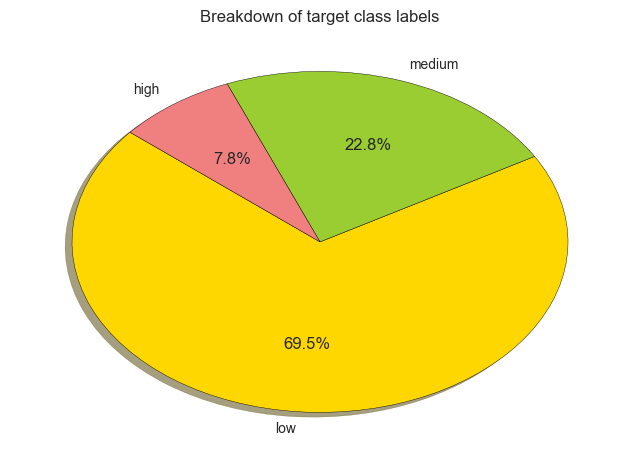

In [8]:
# lets look at the distribution of the different target classes within the training dataset
class_sizes = train['interest_level'].value_counts().values
labels = ['low', 'medium', 'high']
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(class_sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Breakdown of target class labels")
plt.show()

We can observe class imbalance within the training set, where the 3 interest_levels are not represented equally. This could mean that our predicted results are only valid with the underlying distribution, affecting the ability of our model to generalised to other datasets. 

### Extreme Value Analysis

In this section, we want to look at the distribution of numerical variables, paying special attention to the presence of any outliers that we can remove before training the model. Doing this step first will help us reduce noise.

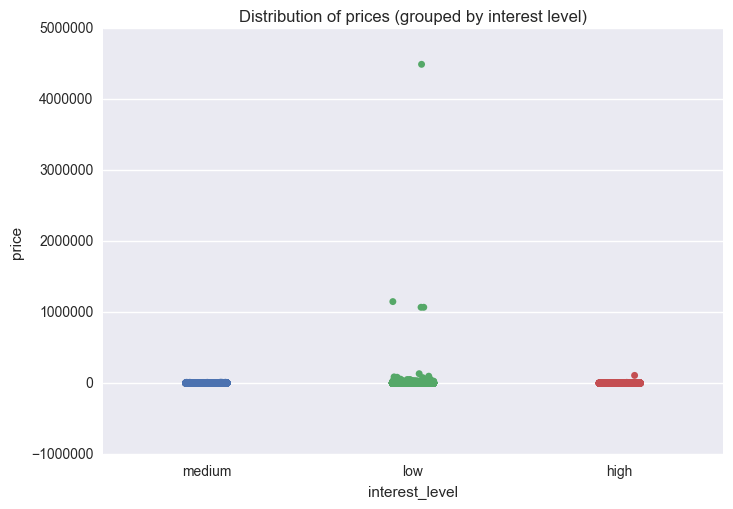

In [9]:
sns.stripplot(train['interest_level'], train['price'], jitter=True)
plt.title('Distribution of prices (grouped by interest level)')
plt.show()

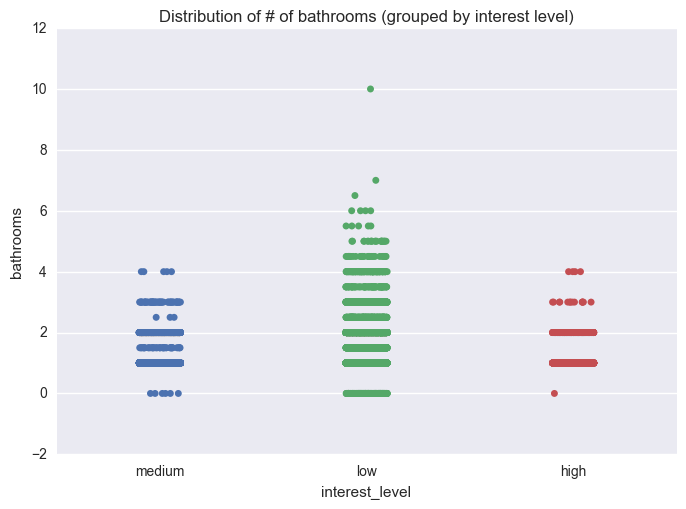

In [10]:
sns.stripplot(train['interest_level'], train['bathrooms'], jitter=True)
plt.title('Distribution of # of bathrooms (grouped by interest level)')
plt.show()

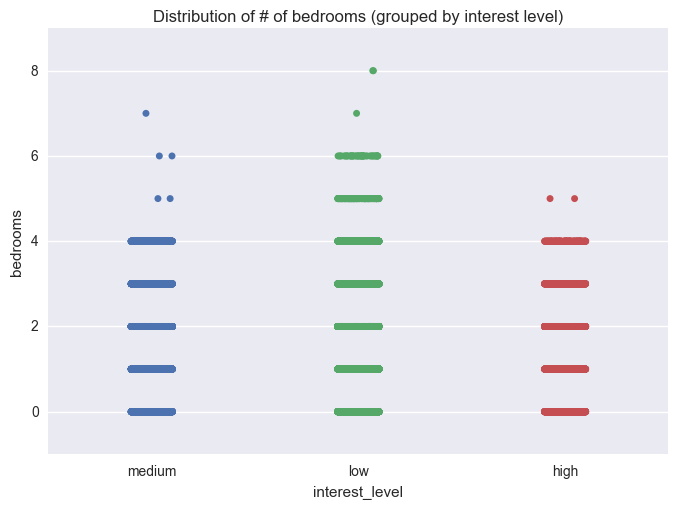

In [11]:
sns.stripplot(train['interest_level'], train['bedrooms'], jitter=True)
plt.title('Distribution of # of bedrooms (grouped by interest level)')
plt.show()

From the above scatter plots, we already observe outliers that can be removed! For example, there is a single listing with 10 bathrooms, and another with a price tag of almost $5m. 

In [12]:
# removing the outliers from the data
train = train[train['price'] < np.percentile(train.price.values, 99)] # remove price outliers
train = train[train['bathrooms'] < 10] # remove bathroom outlier

<center><h3>Baseline Model</h3></center>

Let's build a baseline model with the minimal amount of preparation we have done with the dataset. This will allow us to evaluate further actions against. We will only consider the numerical features for now.

In [13]:
# lets first define a helper function that will help us evaluate our model against a few metrics
def evaluate(clf, X_test, Y_test, clf_name):
    print("===== {} =====".format(clf_name))
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    
    print("Accuracy: {}".format(accuracy_score(Y_test, predicted)))
    print("Log Loss: {}".format(log_loss(Y_test, predicted_prob)))
    labels = ['low', 'medium', 'high']

    print("Confusion Matrix:")
    display(pd.DataFrame(data=confusion_matrix(Y_test, predicted, labels=['low', 'medium', 'high']), index=labels, columns=labels))
    
    print("Report:")
    print(classification_report(Y_test, predicted))

In [14]:
# extract X and Y
y_train = train['interest_level'].values
x_train = train[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']] # use only numerical features

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "Baseline Model (numerical features only)")

===== Baseline Model (numerical features only) =====
Accuracy: 0.6871033776867963
Log Loss: 2.932473454528473
Confusion Matrix:


,low,medium,high
low,5796,775,179
medium,1345,692,231
high,286,241,225


Report:
             precision    recall  f1-score   support

       high       0.35      0.30      0.32       752
        low       0.78      0.86      0.82      6750
     medium       0.41      0.31      0.35      2268

avg / total       0.66      0.69      0.67      9770



<center><h3>Feature Engineering</h3></center>

Now that we have a baseline model, we can start to explore the data again to see how we can extract other features, that can be used to improve our predictions.

### Feature Discretization

There is a whole lot of data that we are ignoring when we only look at numerical features. One way to get more utility out of the data is to discretize some non-numerical features into classes. 

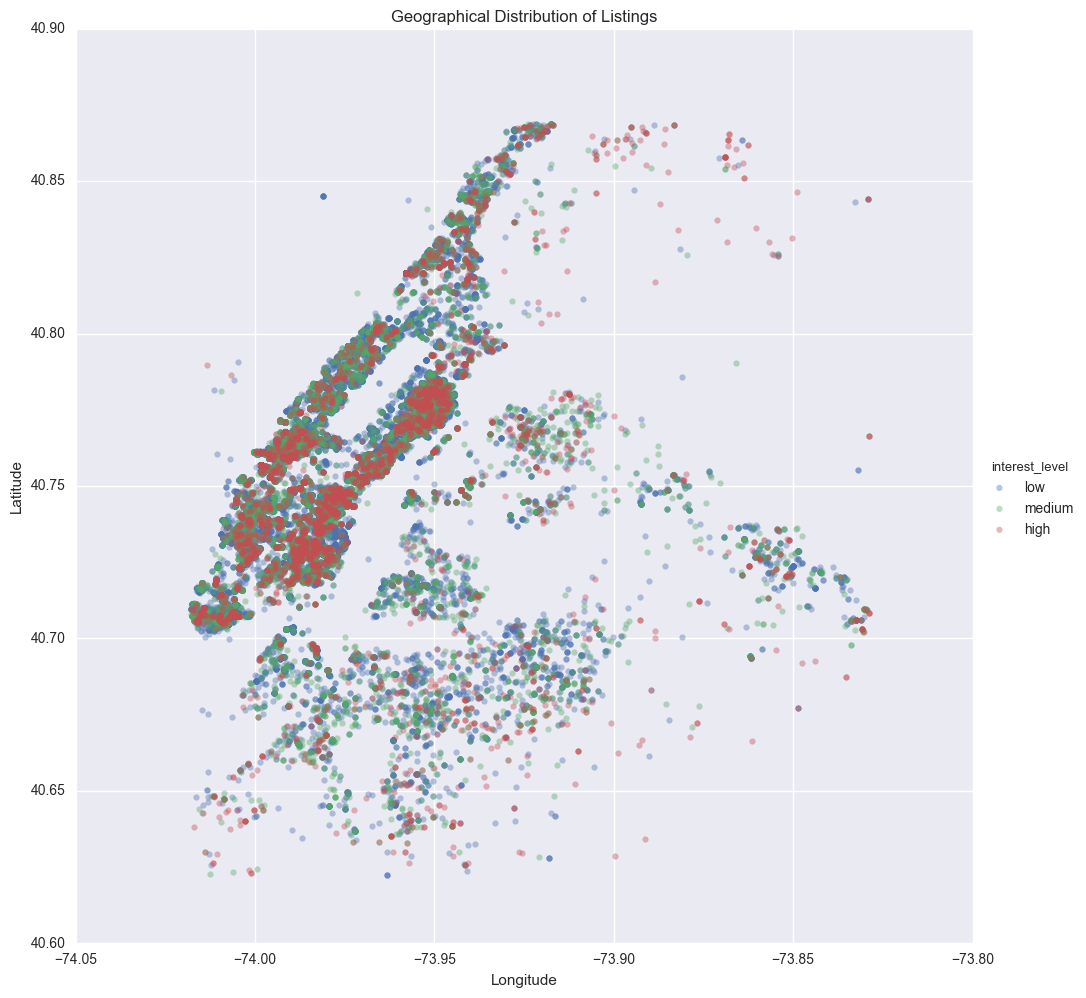

In [15]:
# first, we look at the location information (lat and lng)
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=10, scatter_kws={'alpha':0.4},
           data=train[(train.longitude>train.longitude.quantile(0.005)) # remove outliers so we can get a better view
                           &(train.longitude<train.longitude.quantile(0.995))
                           &(train.latitude>train.latitude.quantile(0.005))                           
                           &(train.latitude<train.latitude.quantile(0.995))])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographical Distribution of Listings")
plt.show()

There seems like there could be some clustering of high interest listings, which means that location could be a useful predictor. Instead of using the raw latitude/longitude values, we hypothesize that we can reduce noise and increase accuracy by looking up the exact neighborhood instead.

In [16]:
# add a new neighborhood column

def get_neighborhood(latlng):
    return
    res = geo.google(latlng.tolist(), method='reverse')
    return res.neighborhood    

# train.assign(neighborhood=[get_neighborhood(x) for x in train[['latitude', 'longitude']].values])

We can also make use of `LabelBinarizer` to start making use of the categorical variables in our dataset to train the model. We will do this pre-processing step on building_id and manager_id. 

In [17]:
from sklearn import preprocessing
lb_managerid = preprocessing.LabelBinarizer()
lb_managerid.fit(train['manager_id'])
lb_buildingid = preprocessing.LabelBinarizer()
lb_buildingid.fit(train['building_id'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [18]:
managerids = pd.DataFrame(lb_managerid.transform(train['manager_id']))
buildingids = pd.DataFrame(lb_buildingid.transform(train['building_id']))

In [19]:
train1 = train.reset_index() # so there are no problems concatenating
train1 = train1.drop('index', axis=1)
train1 = pd.concat([train1, managerids, buildingids], axis=1)
train1 = train1.drop(['building_id', 'manager_id'], axis=1)

While we are not using any form of image recognition in our model just yet, our intuition is that the number of photos that a listing has should also affect its interest level. Let's make that into a feature too.

In [20]:
train1 = train1.assign(photo_count=[len(photos) for photos in train1['photos'].values])

Let's see how our model improves now with after all these steps

In [21]:
# extract X and Y
y_train = train1['interest_level'].values
x_train = train1.drop(['interest_level', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After applying discretization to categorical variables")

===== After applying discretization to categorical variables =====
Accuracy: 0.7241555783009211
Log Loss: 2.208703395899993
Confusion Matrix:


,low,medium,high
low,6115,557,78
medium,1353,735,180
high,266,261,225


Report:
             precision    recall  f1-score   support

       high       0.47      0.30      0.36       752
        low       0.79      0.91      0.84      6750
     medium       0.47      0.32      0.38      2268

avg / total       0.69      0.72      0.70      9770



### Extracting Textual Features

This dataset is interesting because in addition to numerical features, we also have 2 fields with textual data. We shall visualize them to see if we can find a meaningful way to use them.

In [22]:
train['features'].values

array([[],
       ['Doorman', 'Elevator', 'Fitness Center', 'Cats Allowed', 'Dogs Allowed'],
       ['Laundry In Building', 'Dishwasher', 'Hardwood Floors', 'Pets Allowed Case by Case'],
       ...,
       ['Doorman', 'Elevator', 'Pre-War', 'Dogs Allowed', 'Cats Allowed'],
       ['Doorman', 'Elevator', 'Pre-War', 'Dogs Allowed', 'Cats Allowed'],
       ['Hardwood Floors']], dtype=object)

In [23]:
# accumulate word tokens from text fields
feature_arr = []
description_arr = []
for w in train['features'].values:
    feature_arr.extend(w)
for w in train['description'].values:
    description_arr.extend(w.split())

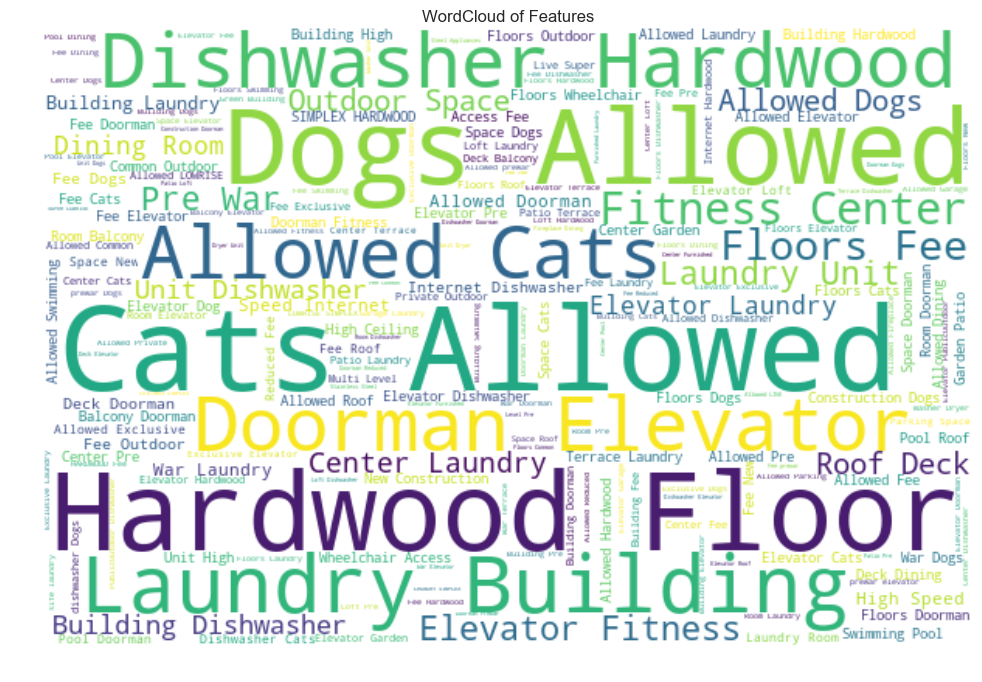

In [24]:
wordcloud = WordCloud(background_color='white', width=600, height=400).generate(' '.join(feature_arr))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Features')
plt.show()

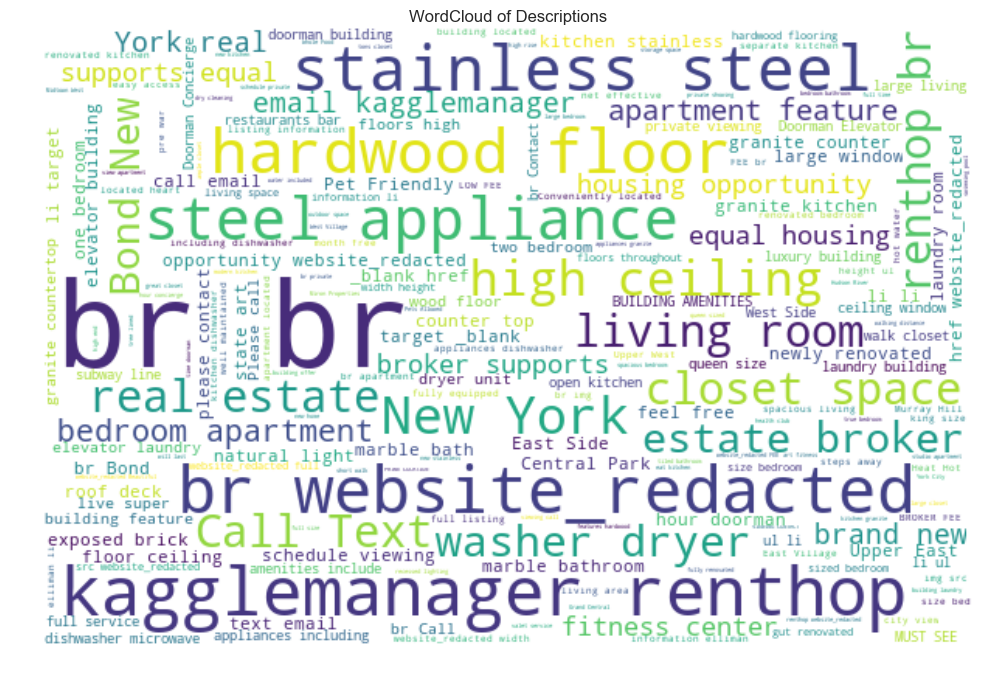

In [25]:
wordcloud = WordCloud(background_color='white', width=600, height=400).generate(' '.join(description_arr))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Descriptions')
plt.show()

Based on the the word clouds, we realise that many of the textual features are characteristics of an apartment that could be of significant interest to the renter. Therefore, we might be able to improve our predictions using the occurence of these words. Let's first use the `MultiLabelBinarizer` to breakdown the features array into multiple binary features.

In [26]:
# extract features and their count
feature_dict = {}
for f in feature_arr:
    if f in feature_dict:
        feature_dict[f] = feature_dict[f] + 1 
    else: 
        feature_dict[f] = 1

# remove features that are rare to reduce noise
rare_features = []
for k,v in feature_dict.items():
    if v <= 1:
        rare_features.append(k)
        
def remove_rare(features):
    result = []
    for f in features:
        if f not in rare_features:
            result.append(f)
    return result

train1['features'] = train1['features'].map(remove_rare)

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(train1['features'])

feature_columns = pd.DataFrame(mlb.transform(train1['features']))
train1 = pd.concat([train1, feature_columns], axis=1)

In [28]:
# extract X and Y
y_train = train1['interest_level'].values
x_train = train1.drop(['interest_level', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After adding feature labels")

===== After adding feature labels =====
Accuracy: 0.7167860798362333
Log Loss: 2.066513124948998
Confusion Matrix:


,low,medium,high
low,6179,497,74
medium,1453,626,189
high,331,223,198


Report:
             precision    recall  f1-score   support

       high       0.43      0.26      0.33       752
        low       0.78      0.92      0.84      6750
     medium       0.47      0.28      0.35      2268

avg / total       0.68      0.72      0.69      9770



We found that adding features to our model actually decreased the accuracy of our model (from 0.72 to 0.71), but also improved the log loss score (2.15 to 2.01). This means that the model made lesser wrong predictions with high confidence. 

Next, we move on to look at the description field. Since this field has free form text, we will extract the most common 2 and 3 ngrams present in the features column. This will yield us a list of phrasal features that we can extract and use as binary labels.

We will use a tunable `WORD_FREQ_THRESHOLD` that limits the ngrams generated to only the n most common phrases. After some experimentation, we found that 20 is the optimum value that gives the best improvement over the base model. 

In [32]:
import re
WORD_FREQ_THRESHOLD = 20
from sklearn.feature_extraction.text import CountVectorizer

# from our prior visualisation, we notice that there are alot of html tag fragments
# remove them to get cleaner results
tagsregex = re.compile('<.*?>')
def cleandesc(token):
    result = re.sub(tagsregex, '', token)
    return ''.join(i for i in result if not i.isdigit())

# we also remove stop words (the, this, them.. etc) since we are dealing with a natural language corpus
desc_3gram = CountVectorizer(input='content', strip_accents='ascii', analyzer='word',
                    ngram_range=(3,3), max_features=WORD_FREQ_THRESHOLD,
                    stop_words='english')
desc_2gram = CountVectorizer(input='content', strip_accents='ascii', analyzer='word',
                    ngram_range=(2,2), max_features=WORD_FREQ_THRESHOLD,
                    stop_words='english')

cleaned_descriptions = [cleandesc(x) for x in train1['description'].values]

desc_3gram.fit(cleaned_descriptions)
desc_2gram.fit(cleaned_descriptions)

desc_3gram.get_feature_names(), desc_2gram.get_feature_names()

(['appliances including dishwasher',
  'bond new york',
  'broker supports equal',
  'email kagglemanager renthop',
  'equal housing opportunity',
  'estate broker supports',
  'floor ceiling windows',
  'floors high ceilings',
  'granite counter tops',
  'hardwood floors high',
  'housing opportunity website_redacted',
  'kagglemanager renthop com',
  'kitchen stainless steel',
  'new york real',
  'real estate broker',
  'renthop com website_redacted',
  'stainless steel appliances',
  'supports equal housing',
  'washer dryer unit',
  'york real estate'],
 ['apartment features',
  'bedroom apartment',
  'brand new',
  'broker supports',
  'closet space',
  'com website_redacted',
  'email kagglemanager',
  'equal housing',
  'estate broker',
  'hardwood floors',
  'high ceilings',
  'kagglemanager renthop',
  'living room',
  'new york',
  'real estate',
  'renthop com',
  'stainless steel',
  'steel appliances',
  'washer dryer',
  'york real'])

In [33]:
# now, lets create new columns to encode the presence of these ngrams
desc = [cleandesc(x) for x in train1['description'].values]
desc_2gram_df = pd.DataFrame(desc_2gram.transform(desc).toarray())
desc_3gram_df = pd.DataFrame(desc_3gram.transform(desc).toarray())

train2 = pd.concat([train1, desc_2gram_df, desc_3gram_df], axis=1)

In [34]:
# extract X and Y
y_train = train2['interest_level'].values
x_train = train2.drop(['interest_level', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After adding textual features")

===== After adding textual features =====
Accuracy: 0.7098259979529171
Log Loss: 1.9776975923707973
Confusion Matrix:


,low,medium,high
low,6191,487,72
medium,1535,570,163
high,359,219,174


Report:
             precision    recall  f1-score   support

       high       0.43      0.23      0.30       752
        low       0.77      0.92      0.83      6750
     medium       0.45      0.25      0.32      2268

avg / total       0.67      0.71      0.67      9770



Unfortunately, this version with ngrams from the descriptions actually performs worse than the previous one. We hypothesized that it was due to the fact that the ngrams we extracted programatically included some that had no semantic meaning, for example, we had "york real", or "renthop com website_redacted". Let's create a new `CountVectorizer` that reads from our custom dictionary, using **only** meaningful ngrams from the previous step.

In [35]:
# create new CountVectorizer with only meaningful ngrams
custom_vocab = CountVectorizer(input='content', strip_accents='ascii', analyzer='word',
                    ngram_range=(2,3), stop_words='english')
custom_vocab.fit([
  'ample closet space',
  'appliances including dishwasher',
  'fitness center',
  'hardwood floors',
  'equal housing opportunity',
  'estate broker supports',
  'feel free contact',
  'high ceilings',
  'granite counter tops',
  'great closet space',
  'hot water',
  'hot water included',
  'information schedule viewing',
  'large living room',
  'new stainless steel',
  'spacious living room',
  'stainless steel appliances',
  'stainless steel kitchen',
  'state art fitness',
  'supports equal housing',
  'washer dryer unit',
  'bedroom apartment',
  'brand new',
  'central park',
  'closet space',
  'counter tops',
  'exposed brick',
  'fitness center',
  'granite counter',
  'granite kitchen',
  'hardwood floors',
  'high ceilings',
  'hour doorman',
  'kitchen stainless',
  'laundry room',
  'living room',
  'marble bathroom',
  'natural light',
  'new york',
  'newly renovated',
  'real estate',
  'roof deck',
  'stainless steel',
  'state art',
  'steel appliances',
  'washer dryer',
  'subway line',
  'short walk',
  'natural light',
  'pet friendly'
])

custom_vocab.vocabulary_

{'ample closet': 0,
 'ample closet space': 1,
 'appliances including': 2,
 'appliances including dishwasher': 3,
 'art fitness': 4,
 'bedroom apartment': 5,
 'brand new': 6,
 'broker supports': 7,
 'central park': 8,
 'closet space': 9,
 'counter tops': 10,
 'dryer unit': 11,
 'equal housing': 12,
 'equal housing opportunity': 13,
 'estate broker': 14,
 'estate broker supports': 15,
 'exposed brick': 16,
 'feel free': 17,
 'feel free contact': 18,
 'fitness center': 19,
 'free contact': 20,
 'granite counter': 21,
 'granite counter tops': 22,
 'granite kitchen': 23,
 'great closet': 24,
 'great closet space': 25,
 'hardwood floors': 26,
 'high ceilings': 27,
 'hot water': 28,
 'hot water included': 29,
 'hour doorman': 30,
 'housing opportunity': 31,
 'including dishwasher': 32,
 'information schedule': 33,
 'information schedule viewing': 34,
 'kitchen stainless': 35,
 'large living': 36,
 'large living room': 37,
 'laundry room': 38,
 'living room': 39,
 'marble bathroom': 40,
 'natu

In [36]:
# now, lets create new columns to encode the presence of these ngrams
desc = [cleandesc(x) for x in train1['description'].values]
custom_vocab_df = pd.DataFrame(custom_vocab.transform(desc).toarray())

train2 = pd.concat([train1, custom_vocab_df], axis=1)

# extract X and Y
y_train = train2['interest_level'].values
x_train = train2.drop(['interest_level', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After adding textual features (only meaningful ones)")


===== After adding textual features (only meaningful ones) =====
Accuracy: 0.7132036847492323
Log Loss: 1.9697981492955041
Confusion Matrix:


,low,medium,high
low,6234,455,61
medium,1554,555,159
high,360,213,179


Report:
             precision    recall  f1-score   support

       high       0.45      0.24      0.31       752
        low       0.77      0.92      0.84      6750
     medium       0.45      0.24      0.32      2268

avg / total       0.67      0.71      0.68      9770



Other ideas of things to look at: 

- Number of listings in the same building
- Number of listings managed by the same manager
- Date? Not sure if this is a useful feature to look at
- Number of photos?
- Number of features?
- Clustering of coordinates into grids (can round off latlng values)
- API to lookup the neighborhood